# Week 1 Lab: next generation sequencing and mutation hunting

## Prelab 2

**Due: Monday 4/8/19 9am**

Today's prelab will focus on understanding **sequencing coverage** and how to model coverage in the presence of **genetic variants** from the reference genome.

## 1. Exploring sequencing coverage

In next generation sequencing (NGS), coverage refers to the number of reads *covering* a particular base pair (bp) in the reference genome.

Recall from lecture that we sequence a genome in many little chunks, called *reads*. In a typical NGS experiment, reads are around 100bp each. We can assume that the start position of each read is chosen randomly from the genome (although that's not quite true). We usually produce enough sequencing data such that we cover each base in the genome many times. This allows us to more accurately correct for errors and to detect **variants** from the reference genome.

As a toy example, consider the following reference genome and read alignment:

```
Ref:    AACTACGTACGTACGATCAGACTG
Read 1:      CGTACG
Read 2:          CGTACG
Read 3:                  CAGACT
```

The 11th position (G in the reference) is covered 2 times (often denoted as 2x). The first position (A in the reference) is covered 0 times. 

**Question 1 (1 pts):** How many times is the 13th base covered?

The 13th base is A. It is covered only one time.

We can easily compute the *average coverage*, or mean number of times each base is covered, given the read length ($l$), genome size ($G$), and number of reads ($N$) by dividing the number of total sequenced bases ($l*N$) by the total genome size ($G$): 

$$\texttt{Mean Coverage} = \frac{lN}{G}$$

**Question 2 (2 pts):** For a genome of total length 2000bp, you sequenced 100,000 reads with length 36. What is the mean coverage?

Mean Coverage is: (36)*(100,000)/(2000) = 1800 reads per bp

**Question 3 (2 pts):** You would like to sequence a human genome (3 billion bp) to mean coverage 50x. Approximately how many 100bp reads should you generate?

Want 50x (MC) coverage for a 3*10^9 (G) length sequence while using 100bp per read.

Number of reads needed: (3 * 10^9)*(50)/(100) = 1,500,000,000

## 2. Reviewing the binomial distribution

Now we will explore what our sequencing data will look like in the presence of variants from the reference genome. We'll also learn some terminology for how we talk about genetic variation. For simplicity, we will only consider simple base pair substitutions. Insertions, deletions, or structural variants will be discussed in later weeks.

Humans are *diploid*, meaning we have two copies of each chromosome (except X and Y). Positions in the genome that have common variants in the population are referred to as "single nucleotide polymorphisms", or SNPs. Nearly all SNPs are *bi-allelic*, meaning the position on any given copy of the chromosome in the population is either one of two possible base pairs (e.g. A or C). Each of these possible base pairs is called an *allele*.

For example, consider a SNP with two alleles, "C" or "T". Since we are diploid, the *genotype* of a person consists of the two alleles they have on either copy. So a person's *genotype* at this SNP could be either CC, CT, or TT. We refer to genotypes where both alleles are the same (e.g. CC or TT) as *homozygous* and to genotypes with two different alleles (e.g. CT) as *heterozygous*. Since one of these is usually the allele in the reference genome (*reference allele*), we can refer to SNP genotypes as *homozygous reference*, *heterozygous*, or *homozygous non-reference*.

Now let's think about what next-generation sequencing data will look like at different types of genotypes. Consider a position in the genome *covered* by $C$ reads. Each of those reads has a 50/50 chance of coming from either chromosome of an individual. For a homozygous position (e.g. genotype TT), we'd expect all of the reads covering that position to show the same base pair (T). On the other hand, for a heterozygous position (e.g. genotype CT), we'd expect about half of them to show one base pair (C) and half the other (T). (Of course when there are sequencing errors, this will change.)

The *binomial distribution* is a great way to model the number of reads with each allele at a heterozygous position. Head over to wikipedia to refresh your memory on this distribution: https://en.wikipedia.org/wiki/Binomial_distribution.

In a binomial distribution, we have $N$ total "trials", each with probability $p$ of "success". Then the probability of observing $k$ "successes" is:

$$ P(k) = {n \choose k} p^k(1-p)^{n-k}$$

Now let's adapt this to SNP calling. 

Let $N$ (number of trials) be the total number of reads covering a position and a "success" mean observing a non-reference allele. Since we observe each allele (reference vs. non-reference) with 50/50 chance, $p=0.5$. Then for a heterozygous position:

$$ P(\texttt{observe }k\texttt{ non-reference reads} | \texttt{het}) = {n \choose k} 0.5^k(1-0.5)^{n-k}$$
Simplifying:
$$ P(\texttt{observe }k\texttt{ non-reference reads} | \texttt{ het}) = {n \choose k} 0.5^n$$

And for the homozygous cases are just:
$$ P(\texttt{observe }k\texttt{ non-reference reads} | \texttt{ hom. ref}) = \begin{array}{c c} 1 & k=0 \\ 0 & k>0\end{array}$$
$$ P(\texttt{observe }k\texttt{ non-reference reads} | \texttt{ hom. nonref}) = \begin{array}{c c} 1 & k=N \\ 0 & k<N \end{array}$$

This of course gets more complicated when you consider sequencing errors. That is, even if a position is homozygous for the reference allele, you may occasionally see evidence for a different base due to an error. But let's ignore that for now.

Let's plot the distributions for a SNP with C as the reference allele and T as the non-reference allele that we covered 50 times:

Populating the interactive namespace from numpy and matplotlib


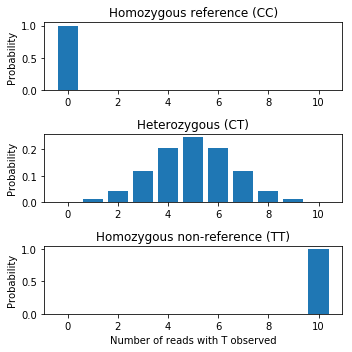

In [3]:
%pylab inline

import numpy as np
import scipy.special

def GetHomRefProb(N, k):
    """Probability to see k non-ref reads at a homozygous ref site with N total reads"""
    if k == 0: return 1
    else: return 0
    
def GetHetProb(N, k):
    """Probability to see k non-ref reads at a heterozygous site with N total reads"""
    return scipy.special.comb(N, k)*0.5**N

def GetHomNonRefProb(N, k):
    """Probability to see k non-ref reads at a homozygous non-ref site with N total reads"""
    if k == N: return 1
    else: return 0

def PlotBinomSNP(N):
    """ Plot binomial probabilities for percent of nref reads given N total reads"""
    kvals = range(0, N+1)

    fig = plt.figure()
    fig.set_size_inches((5, 5))

    ax = fig.add_subplot(311)
    hom_ref = [GetHomRefProb(N, k) for k in kvals]
    ax.bar(kvals, hom_ref)
    ax.set_title("Homozygous reference (CC)")
    ax.set_ylabel("Probability")

    ax = fig.add_subplot(312)
    het = [GetHetProb(N, k) for k in kvals]
    ax.bar(kvals, het)
    ax.set_title("Heterozygous (CT)")
    ax.set_ylabel("Probability")

    ax = fig.add_subplot(313)
    hom_nonref = [GetHomNonRefProb(N, k) for k in kvals]
    ax.bar(kvals, hom_nonref)
    ax.set_title("Homozygous non-reference (TT)")
    ax.set_xlabel("Number of reads with T observed")
    ax.set_ylabel("Probability")

    fig.tight_layout()

N = 10 # Number of reads at a position
PlotBinomSNP(N)

**Question 4 (1 pts):** If the position is heterozygous for the reference allele (C) and another allele (T) and there are 10 reads covering it, what is the probability to see only 1 non-reference (T) read?

In [9]:
# Set the value of prob to the probability to see only 1 non-reference (T) read
# Hint: you may use a function defined above
prob = 0 
#def GetHetProb(N, k):
prob = GetHetProb(10,1)
print("Probability is: ", prob)

Probability is:  0.009765625


In [13]:
""" Check probability was computed correctly"""
# Note, some cases (like this) will include visible tests as well as hidden tests that you can't see.
assert(prob>=0 and prob <=1)

**Question 5 (3 pts):** Generate plots similar to above except with 50 reads. Try again with only 3 reads. (do this by executing the code below). Do you think it will be easier or harder to distinguish heterozygous from non-heterozygous positions? What about for a position only covered by 3 reads?

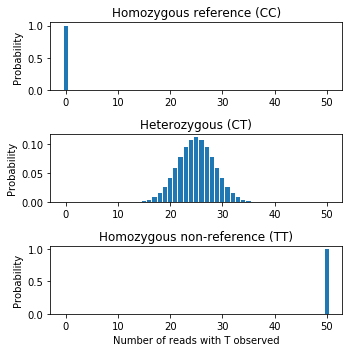

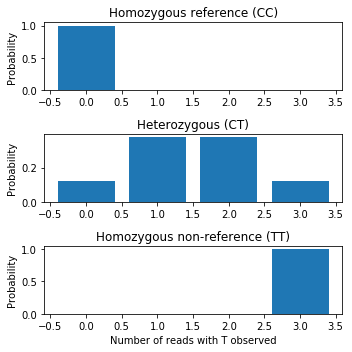

In [14]:
PlotBinomSNP(50)
PlotBinomSNP(3)

It is easier to distinguish between heterozygous and non-heterozygous positions when there are more reads (50). This reduces the effect that potential errors or noise can have in position reads. As seen in the example with only 3 reads, a single change between 0 reads and 1 read changes the probability of heterozygous significantly. The model is a lot more sensative to noise.